In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from matplotlib import pyplot as plt

# can be installed using 
# pip install protfasta
# for docs see https://protfasta.readthedocs.io/
import protfasta

# file found locally (fully documented)
import disprot_parser

# can be installed using 
# pip install metapredict
# for docs see https://metapredict.readthedocs.io/
import metapredict as meta



In [2]:
# defin CAID prediction files. These files are provided in the `data/` directory but were originally generated as part of the CAID data,
# so if you use them please cite this paper [1] and there's no need to cite metapredict!
# [1] Critical assessment of protein intrinsic disorder prediction, Nature Methods 2021
filenames = ['D001_PyHCA.out', 'D002_Predisorder.out', 'D003_IUPred2A-long.out', 'D004_IUPred2A-short.out', 'D005_IUPred-long.out', 'D006_IUPred-short.out', 'D007_FoldUnfold.out', 'D008_IsUnstruct.out', 'D009_GlobPlot.out', 'D010_DisPredict-2.out', 'D011_DISOPRED-3.1.out', 'D013_fIDPln.out', 'D014_fIDPnn.out', 'D015_VSL2B.out', 'D016_DisEMBL-HL.out', 'D017_DisEMBL-465.out', 'D018_ESpritz-D.out', 'D019_ESpritz-N.out', 'D020_ESpritz-X.out', 'D021_MobiDB-lite.out', 'D022_S2D-1.out', 'D023_S2D-2.out', 'D024_DisoMine.out', 'D025_RawMSA.out', 'D026_AUCpreD.out', 'D027_AUCpreD-np.out', 'D028_SPOT-Disorder1.out', 'D029_SPOT-Disorder2.out', 'D030_SPOT-Disorder-Single.out', 'D031_JRONN.out', 'D032_DFLpred.out', 'D033_DynaMine.out']

### Read in DISPROT data

#### NB: This notebook is almost identical to the notebook used in the original paper, but we've added in selectors for V2

This first cell parses through the DISPROT data (defined in `../../accuracy/data` by the files `disprot-2018-*` and `pdb-atleast.fasta` to generate a reliable dataset with which we'll evaluate our predictors on. 

When this repository is first cloned the raw data for these files is compressed. To fix this, unpack the data by moving into the `../../accuracy/data` directory and running:

    ./extract.sh
    
This will extract out the individual files needed by this notebook. To remove these run 

    ./cleanup.sh
    
   
This dataset divides each residue in each DISPROT data into one of three classes:

* `1` - Disorder - as defined by DISPROT disorder data and not being structured in the PDB data
* `0` - Structured - as defined by the PDB data and not being disordered as reproted by the DISPROT data
* `-2` - Ambigious - EITHER no data or conflicting data between DISPROT and PDB data

Our assessment of the predictors is ONLY done over residues that match residue types 1 and 0 as defined above.

In [4]:
# read in disprot data
DISPROT = disprot_parser.parse_disprot(datadir='../../accuracy/data/')
print(f'Found complete data data for {len(DISPROT)} proteins')

Found complete data data for 1041 proteins


## Evaluate  predictors
The code below evaluates each of the predictors using the DISPROT data defined above. Specifically, for each predictor file we read in the data associated with that predictor, where each predictor has a binary 'disordered' (1) or not disordered (0) score associated with each residue. We simply count the number of residues the predictor gets right vs. the number of residues it gets wrong, which for each predictor are added to the `valids` and `invalids` lists below.

Note, as discussed we only evaluate on DISPROT residues where disorder/structure has been unambigiously assigned.

Finally, this gives rise to evaluation of each predictor over around 145K amino acids (i.e. ~1000 different protein sequences).

In [6]:

# valids and invalids will become lists with residue counts for each predictor
valids = []
invalids = []

# names will become a lists with strings that represent each predictor's name
names = []


# cycle over each filename in the filenames list defined above
for fn in filenames:
    print(fn)
    
    # partse the disprot predictor file (see code i disprot_parser.py for more details), but pred is a dictionary
    # where keys are DISPROT IDs and Values are Protein objects, a class we define in disprot_parser.py which is basically
    # just a STRUCT for storing structured data.
    pred = disprot_parser.parse_file(f'../../accuracy/data/{fn}')
    
    # pull out the name
    name = fn.split('_')[1].split('.')[0]
    names.append(name)

    
    valid_fail = []
    
    # for each disprot ID found in the predictor we'll ask if we also have DISPROT ID for it, and, if yes,
    # we'll then evaluate agreement as described above
    for did in pred:
        
        if did in DISPROT:            
            valid_fail.append(disprot_parser.calculate_residue_count(DISPROT[did].disorder_binary, pred[did].disorder_binary))

            
    # when we get here valid_fail is a list of tuples, where the 1st position ([0]) in the tuple is, for each protein,
    # the number of residues the predictor got right and the 2nd position ([1]) is the the number of residues the
    # predictor got wrong. We simply sum these up so that for each predictor we have the TOTAL number of correct 
    # and incorrect residues, which we then add to the valids and invalids lists
    valids.append(np.sum(np.array(valid_fail),0)[0])
    invalids.append(np.sum(np.array(valid_fail),0)[1])
    
res_correct_per_100 = 100*(np.array(valids)/np.sum([valids, invalids],0))    
with open('accuracy_correct_per_100.tsv','w') as fh:
    for i in range(len(filenames)):
        fh.write(f'{filenames[i][0:-4]}\t{res_correct_per_100[i]}\n')

D001_PyHCA.out
D002_Predisorder.out
D003_IUPred2A-long.out
D004_IUPred2A-short.out
D005_IUPred-long.out
D006_IUPred-short.out
D007_FoldUnfold.out
D008_IsUnstruct.out
D009_GlobPlot.out
D010_DisPredict-2.out
D011_DISOPRED-3.1.out
D013_fIDPln.out
D014_fIDPnn.out
D015_VSL2B.out
D016_DisEMBL-HL.out
D017_DisEMBL-465.out
D018_ESpritz-D.out
D019_ESpritz-N.out
D020_ESpritz-X.out
D021_MobiDB-lite.out
D022_S2D-1.out
D023_S2D-2.out
D024_DisoMine.out
D025_RawMSA.out
D026_AUCpreD.out
D027_AUCpreD-np.out
D028_SPOT-Disorder1.out
D029_SPOT-Disorder2.out
D030_SPOT-Disorder-Single.out
D031_JRONN.out
D032_DFLpred.out
D033_DynaMine.out


### metapredict predictions
Finally we do the same method of evaluation using metapredict with default settings. Notably we cycle over EVERY DISPROT entry to maximize the number of sequences we evaluate against. 

For each sequence the function `disprot_parser.extract_binary_disorder()` takes in the DISPROT sequence, predictors disorder, extracts out the IDRs using the `meta.predict_disorder_domains()` function and converts those boundaries to a list of 0s (structured) and 1s (disordered). That list is then compared againt the true data from DISPROT in the same way as all the other predictors were.

The `%%time` line at the top (and `print()` at the bottom) are there to provide some performance data on how long it takes to evaliate the full metapredict dataset, which on our test machines takes about 60 seconds (where, the slowest CAID predictor takes ~36 days to do the same evaliation).

In [9]:
%%time
metapredict_valid_fail_default = []


for did in DISPROT:    
    metapredict_valid_fail_default.append(disprot_parser.calculate_residue_count(DISPROT[did].disorder_binary, 
                                                             disprot_parser.extract_binary_disorder(DISPROT[did].sequence, mode='v2')))

print()


CPU times: user 52.5 s, sys: 3.88 s, total: 56.4 s
Wall time: 56.5 s


### Compute per 100-residue scores
Final step allows us to take the fraction of correct residues in all residues and multiply by 100 to get a metric that reports on if we predicted 100 residues to be disordered/ordered how many would we get right. This allows us to convert predictor accuracy into a metric we can intuitively make sense of and, importantly, compare between predictors. 

In [10]:
# compute per 100 correct scores
metapredict_per_100 = 100*np.sum(np.array(metapredict_valid_fail_default),0)[0]/np.sum(np.array(metapredict_valid_fail_default))
print(f'Metapredict correct per 100 = {metapredict_per_100}')

## the code below just orderes the data and builds a new ordered list and names list
ordered_data = []
for i in range(len(names)):
    ordered_data.append([res_correct_per_100[i], names[i]])

    
ordered_data = sorted(ordered_data, key=lambda x: x[0], reverse=True)

ordered_data_scores = []
ordered_data_names = []
for i in range(len(ordered_data)):
    ordered_data_scores.append(ordered_data[i][0])
    ordered_data_names.append(ordered_data[i][1])
    

Metapredict correct per 100 = 91.02449508733625


meta NOT subset; don't know how to subset; dropped


0.5135405172360663


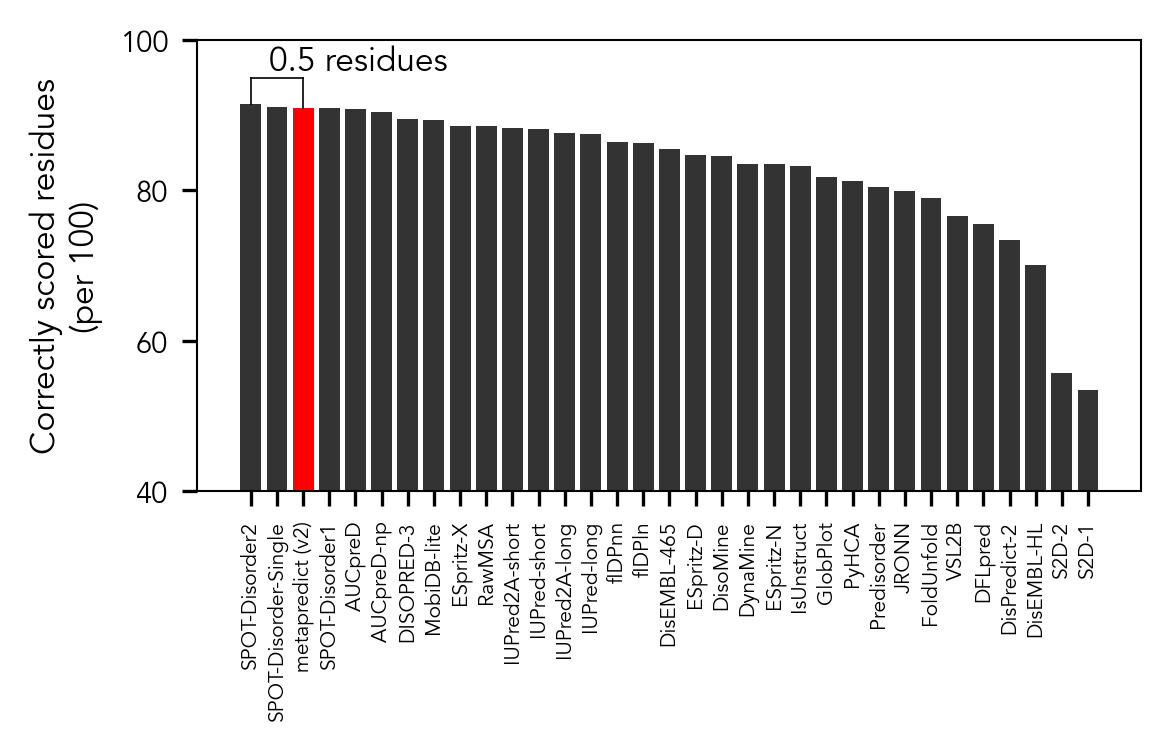

In [22]:
figure(num=None, figsize=(4, 2.6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()

# this builds ordered data wuth a gap for metapredict (done manually)
s1 = ordered_data_scores[0:2]
s1.extend([0])
s1.extend(ordered_data_scores[2:])

n1 = ordered_data_names[0:2]
n1.extend(['metapredict (v2)'])
n1.extend(ordered_data_names[2:])


plt.bar(np.arange(1,len(s1)+1), s1, color='k', alpha=0.8)
#plt.plot([1,len(filenames)+1],[metapredict_per_100,metapredict_per_100])
plt.bar([3],[metapredict_per_100], color='r')
plt.ylim([40,100])
plt.yticks(fontsize=7)
plt.ylabel('Correctly scored residues\n(per 100)',fontsize=8)
plt.xticks(np.arange(1,len(n1)+1), n1, fontsize=5, rotation=90)
print(s1[0]-metapredict_per_100)

# plot lines for visually comparing
plt.plot([1,1],[s1[0],95],'-k', linewidth=0.4)
plt.plot([1,3],[95,95],'-k', linewidth=0.4)
plt.plot([3,3],[95, metapredict_per_100],'-k', linewidth=0.4)
plt.text(1.7,96,'0.5 residues', fontsize=8)
plt.tight_layout()
plt.savefig('metapredict_v2_vs_all_accuracy_per_100.pdf')
